In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 36b6a277-86a1-4fde-a73f-2ed95257a43d

In [7]:
# Premade libraries
import cv2
import time
import math
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point, LineString

# Homemade functions
import Vision.vision as vs
import robot as rbt
import Global_Navigation.global_navigation as glb
import Motion_Control.thymio_control as ctrl

100%|██████████| 2/2 [00:00<00:00, 146.50it/s]


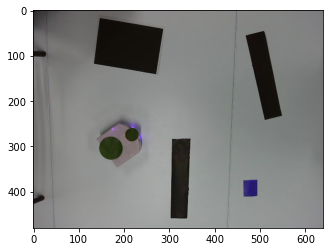

In [8]:
cap = cv2.VideoCapture(0)
img = vs.get_image(cap)
margin = 60
tol = 0.1
thymio = rbt.RobotNav()
#j = 0
#COEFF_SPEED = 0.48
#dvx = 0
#dvy = 0
i = 0 #step vis graph
path = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    if thymio.get_state() == 0:
        thymio.initialisation_step(frame, margin, False)
        path = thymio.get_path('real')
        
        pos_thy, two_centres, test_detect = vs.detect_start1(frame, False) 
        #if(j==0):
            #thymio.set_x_est(two_centres)
            #j=1
        thymio.update_position_cam(two_centres, node, client)
        beta = ctrl.get_angle2goal(thymio.get_geometry(),[path[1].x, path[1].y])

        ctrl.get_correct_orientation(beta, node, 50, 0.2)
        if beta < tol:
            thymio.set_state(1)
            ctrl.stop_motors(node)
    
    if thymio.get_state() == 1:
        pos_thy, two_centres, test_detect = vs.detect_start1(frame, False)  
        frame = glb.draw_path(frame, thymio.get_path('real')) 
        path_img = thymio.get_path('img')
        if test_detect:
            frame = glb.draw_thymio(frame, path_img,"")   
        if test_detect:
            #thymio.set_thymio_values(two_centres, node, client)
            #thymio.update_position_kalman(dvx, dvy, node, client, True)
            thymio.update_position_cam(two_centres, node, client)  
        #else:
            #thymio.update_position_kalman(dvx, dvy, node, client, False)
        
        #dvx = 0 
        #dvy = 0
    
        if len(path) > (i+1):
            next_goal = (path[i+1].x,path[i+1].y) 
            pos, teta = thymio.get_geometry()
            temp=ctrl.astolfi(pos, teta, next_goal, node, client) #astolfi controller
            #dvx = COEFF_SPEED*(left_speed+right_speed)*math.cos(teta)/2 - thymio.get_last_vx()
            #dvy = -COEFF_SPEED*(left_speed+right_speed)*math.sin(teta)/2 - thymio.get_last_vy()
            if temp==1:
                i=i+1
        else : 
            ctrl.stop_motors(node)
            ctrl.leds_blink(node)
            break
    cv2.imshow('frame',frame)     
    if cv2.waitKey(1) == ord('q'):
        ctrl.stop_motors(node)
        break
        
cap.release()
cv2.destroyAllWindows()